<a href="https://colab.research.google.com/github/santiagoviteri01/mmia_nlp_2023_2024/blob/main/taller_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN, LSTM, GRU Lab:**
## Ricardo Loor
## Santiago Viteri

In [1]:
pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 20.1 MB/s eta 0:00:00


In [2]:
!pip uninstall torchtext
!pip install torchtext --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.6 MB/s eta 0:00:00


# 1) Setup

In [3]:
from google.colab import drive
import os
import pandas as pd
drive.mount('/content/drive')
import unicodedata
import string
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content


In [4]:
import pandas as pd
import zipfile
import os

# Path to the zip file and the .tsv file inside it

zip_file_path = '/content/drive/MyDrive/train.tsv.zip'
tsv_file_name = 'train.tsv'

# Extract and load the TSV file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(tsv_file_name) as file:
        df = pd.read_csv(file, delimiter='\t')

print(df.head())
values_to_filter = [0, 2, 4]

# Filter the DataFrame
df = df[df['Sentiment'].isin(values_to_filter)]
df['Sentiment'] = df['Sentiment'].replace({2: 1, 4: 2})
df.info()

   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  
<class 'pandas.core.frame.DataFrame'>
Index: 95860 entries, 1 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    95860 non-null  int64 
 1   SentenceId  95860 non-null  int64 
 2   Phrase      95860 non-null  object
 3   Sentiment   95860 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.7+ MB


# 2) Data Processing

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = df['Phrase']
y = df['Sentiment']

In [7]:
# For features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

In [8]:
# Print the shapes to verify
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training set shape: X_train: (76688,), y_train: (76688,)
Test set shape: X_test: (19172,), y_test: (19172,)


## 2.1) Quick EDA

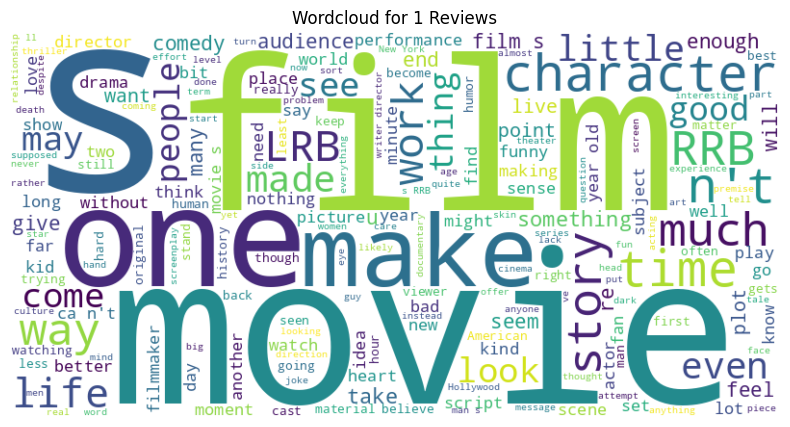

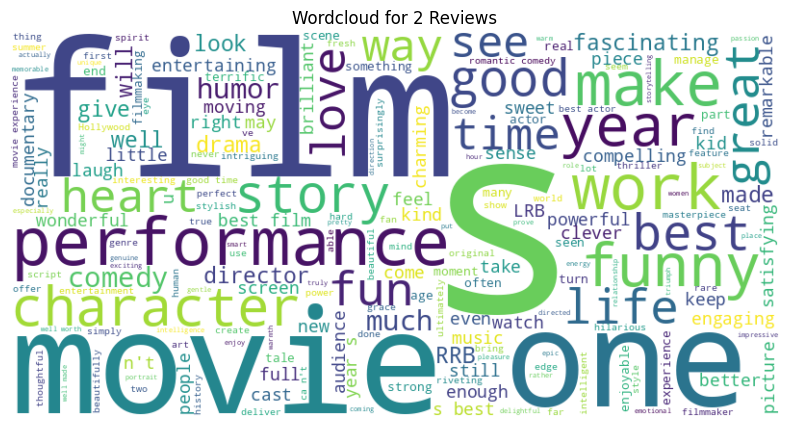

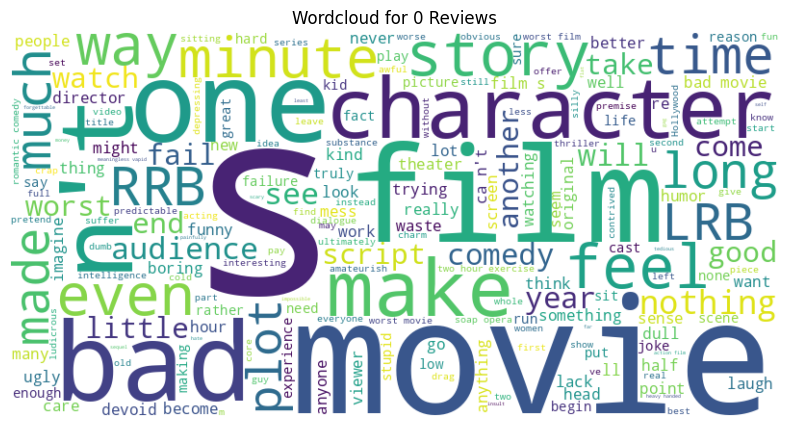

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordcloud(texts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

for sentiment in df['Sentiment'].unique():
    texts = df[df['Sentiment'] == sentiment]['Phrase']
    plot_wordcloud(texts, f'Wordcloud for {sentiment} Reviews')

## 2.2) Dataset and Datamodule



In [10]:
import pandas as pd
import zipfile
import os
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re
import pytorch_lightning as pl

# Define the Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        tokens = self.tokenizer(text)
        indices = torch.tensor([self.vocab.get(token, self.vocab['<unk>']) for token in tokens], dtype=torch.long)
        if len(indices) < self.max_len:
            indices = torch.cat([indices, torch.zeros(self.max_len - len(indices), dtype=torch.long)])
        else:
            indices = indices[:self.max_len]
        return indices, torch.tensor(label, dtype=torch.long)

# Tokenizer and Vocabulary
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def nltk_tokenizer(text):
    if isinstance(text, str):
        return word_tokenize(text.lower())
    return []

def build_vocab(texts):
    counter = Counter()
    for text in texts:
        tokens = nltk_tokenizer(text)
        counter.update(tokens)
    vocab = {token: i + 1 for i, (token, _) in enumerate(counter.items())}
    vocab['<unk>'] = len(vocab) + 1
    return vocab

vocab = build_vocab(X)
vocab_size = len(vocab)
embed_dim = 128
hidden_dim = 64
output_dim = 3
max_len = 50
batch_size = 64

# DataModule
class SentimentDataModule(pl.LightningDataModule):
    def __init__(self, train_texts, train_labels, test_texts, test_labels, vocab, tokenizer, max_len, batch_size):
        super().__init__()
        self.train_texts = train_texts
        self.train_labels = train_labels
        self.test_texts = test_texts
        self.test_labels = test_labels
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = SentimentDataset(self.train_texts, self.train_labels, self.vocab, self.tokenizer, self.max_len)
        self.test_dataset = SentimentDataset(self.test_texts, self.test_labels, self.vocab, self.tokenizer, self.max_len)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)

    def collate_fn(self, batch):
        texts, labels = zip(*batch)
        texts = pad_sequence(texts, batch_first=True, padding_value=0)
        return texts, torch.stack(labels)

# Instantiate the DataModule
data_module = SentimentDataModule(X_train, y_train, X_test, y_test, vocab, nltk_tokenizer, max_len, batch_size)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2.3) Models

In [11]:
import pytorch_lightning as pl
import torch.nn as nn
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


import pytorch_lightning as pl
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, classification_report

class SentimentModel(pl.LightningModule):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, rnn_type='RNN', bidirectional=False):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Determine the RNN type and set bidirectional flag
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)

        # The output dimension of the RNN layer is doubled for bidirectional RNNs
        rnn_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(rnn_output_dim, output_dim)
        self.loss_fn = nn.CrossEntropyLoss()
        self.y_true = []
        self.y_pred = []

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        # Use the output of the last time step
        output = self.fc(output[:, -1, :])
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        self.eval()
        with torch.no_grad():
            outputs = self(x)
            preds = torch.argmax(outputs, dim=1)
            self.y_true.extend(y.cpu().numpy())
            self.y_pred.extend(preds.cpu().numpy())

    def on_test_epoch_end(self):
        f1 = f1_score(self.y_true, self.y_pred, average='weighted')
        report = classification_report(self.y_true, self.y_pred)

        # Log the F1 score
        self.log('test_f1', f1)

        # Print the classification report
        print(f'Weighted F1 Score: {f1}')
        print('Classification Report:')
        print(report)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)



# 3) Train and Evaluate

In [24]:
import pytorch_lightning as pl

# Define and train RNN model
rnn_model = SentimentModel(vocab_size=len(vocab), embed_dim=150, hidden_dim=75, output_dim=3, rnn_type='RNN',bidirectional=False)
trainer = pl.Trainer(max_epochs=10,  devices=1 if torch.cuda.is_available() else "auto")
trainer.fit(rnn_model, data_module)
trainer.save_checkpoint("rnn_model.ckpt")

# Define and train LSTM model
lstm_model = SentimentModel(vocab_size=len(vocab), embed_dim=150, hidden_dim=75, output_dim=3, rnn_type='LSTM',bidirectional=False)
trainer = pl.Trainer(max_epochs=10,  devices=1 if torch.cuda.is_available() else "auto")
trainer.fit(lstm_model, data_module)
trainer.save_checkpoint("lstm_model.ckpt")

# Define and train GRU model
gru_model = SentimentModel(vocab_size=len(vocab), embed_dim=150, hidden_dim=75, output_dim=3, rnn_type='GRU',bidirectional=False)
trainer = pl.Trainer(max_epochs=10,  devices=1 if torch.cuda.is_available() else "auto")
trainer.fit(gru_model, data_module)
trainer.save_checkpoint("gru_model.ckpt")





INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | embedding | Embedding        | 2.5 M  | train
1 | rnn       | LSTM             | 68.1 K | train
2 | fc        | Linear           | 228    | train
3 | loss_fn   | CrossEntropyLoss | 0      | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.146    Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | embedding | Embedding        | 2.5 M  | train
1 | rnn       | GRU              | 51.1 K | train
2 | fc        | Linear           | 228    | train
3 | loss_fn   | CrossEntropyLoss | 0      | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.078    Total estimated model params size (MB)
4         Modules in train mode
0        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# 4) Evaluate and Predict

In [25]:
def evaluate_model(model_path,rnn_type,biderectional):
    model = SentimentModel.load_from_checkpoint(model_path, vocab_size=len(vocab), embed_dim=150, hidden_dim=75, output_dim=3,rnn_type=rnn_type,bidirectional=biderectional) # Added the missing arguments to load_from_checkpoint.
    trainer.test(model, data_module)
    return model

rnn_model = evaluate_model("rnn_model.ckpt", "RNN",False)
lstm_model = evaluate_model("lstm_model.ckpt", "LSTM",False)
gru_model = evaluate_model("gru_model.ckpt","GRU",False)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Weighted F1 Score: 0.7531761812431459
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1415
           1       0.83      1.00      0.91     15916
           2       0.00      0.00      0.00      1841

    accuracy                           0.83     19172
   macro avg       0.28      0.33      0.30     19172
weighted avg       0.69      0.83      0.75     19172



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.7531761527061462     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Weighted F1 Score: 0.909835952313147
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.68      0.66      1415
           1       0.95      0.94      0.95     15916
           2       0.78      0.78      0.78      1841

    accuracy                           0.91     19172
   macro avg       0.79      0.80      0.80     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │     0.909835934638977     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Weighted F1 Score: 0.9127781441982316
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.61      0.66      1415
           1       0.94      0.96      0.95     15916
           2       0.82      0.75      0.79      1841

    accuracy                           0.91     19172
   macro avg       0.83      0.78      0.80     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9127781391143799     │
└───────────────────────────┴───────────────────────────┘

In [27]:
def predict_sentiment(texts, model_path,rnn_model,biderectional):
    model = SentimentModel.load_from_checkpoint(model_path, vocab_size=len(vocab), embed_dim=150, hidden_dim=75, output_dim=3,rnn_type=rnn_model,bidirectional=biderectional) # Added the missing arguments to load_from_checkpoint.
    model.eval()
    with torch.no_grad():
        print(f"RNN TYPE: {rnn_model}")

        for text in texts:
            tokens = nltk_tokenizer(text)
            indices = torch.tensor([vocab.get(token, vocab['<unk>']) for token in tokens], dtype=torch.long).unsqueeze(0)
            output = model(indices)
            prediction = torch.argmax(output, dim=1).item()
            print(f"Text: {text}\nPredicted Sentiment: {prediction}")

# Example
sample_texts = [
    'The movie was amazing! The animation was fantastic.',
    'The movie was awful. I would not recommend it to anyone.'
]
predict_sentiment(sample_texts,"rnn_model.ckpt","RNN",False)
predict_sentiment(sample_texts,"lstm_model.ckpt","LSTM",False)
predict_sentiment(sample_texts,"gru_model.ckpt","GRU",False)


RNN TYPE: RNN
Text: The movie was amazing! The animation was fantastic.
Predicted Sentiment: 0
Text: The movie was awful. I would not recommend it to anyone.
Predicted Sentiment: 0
RNN TYPE: LSTM
Text: The movie was amazing! The animation was fantastic.
Predicted Sentiment: 2
Text: The movie was awful. I would not recommend it to anyone.
Predicted Sentiment: 0
RNN TYPE: GRU
Text: The movie was amazing! The animation was fantastic.
Predicted Sentiment: 2
Text: The movie was awful. I would not recommend it to anyone.
Predicted Sentiment: 0


##  5) Naive Bayes Model with Lemmatization

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download required NLTK data
nltk.download('punkt')
nltk.download('wordnet')

def prepare_and_train(df, text_column, target_column, feature_engineering='none', test_size=0.2, random_state=42):
    """
    Prepares the data by applying the specified feature engineering, converts text to feature vectors,
    splits the data into training and test sets, trains a Naive Bayes model, evaluates it, and makes predictions.

    Parameters:
    - df: pandas DataFrame containing the data.
    - text_column: str, name of the column containing the text data.
    - target_column: str, name of the column containing the target labels.
    - feature_engineering: str, type of feature engineering to apply ('none', 'stop_words', 'stemming', 'lemmatization', 'tfidf').
    - test_size: float, proportion of the dataset to include in the test split (default is 0.2).
    - random_state: int, seed for the random number generator (default is 42).

    Returns:
    - model: Trained Multinomial Naive Bayes model.
    - X_train: sparse matrix of shape (n_samples_train, n_features) with training feature vectors.
    - X_test: sparse matrix of shape (n_samples_test, n_features) with test feature vectors.
    - y_train: pandas Series with training target labels.
    - y_test: pandas Series with test target labels.
    - report: Classification report as a string.
    """

    # Tokenizer functions for stemming and lemmatization
    def stem_tokens(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def lemmatize_tokens(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    def tokenizer_stem(text):
        tokens = word_tokenize(text)
        return stem_tokens(tokens)

    def tokenizer_lemmatize(text):
        tokens = word_tokenize(text)
        return lemmatize_tokens(tokens)

    # Choose the feature engineering method
    if feature_engineering == 'stop_words':
        vectorizer = CountVectorizer(stop_words='english')
    elif feature_engineering == 'stemming':
        vectorizer = CountVectorizer(tokenizer=tokenizer_stem)
    elif feature_engineering == 'lemmatization':
        vectorizer = CountVectorizer(tokenizer=tokenizer_lemmatize)
    elif feature_engineering == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = CountVectorizer()  # Default without stop words, stemming, or lemmatization

    # Convert text to feature vectors
    X = vectorizer.fit_transform(df[text_column])

    # Extract the target labels
    y = df[target_column]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize and train the Naive Bayes model
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Generate classification report
    report = classification_report(y_test, y_pred)

    return model, X_train, X_test, y_train, y_test, report



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# Prepare data, train the model, and get evaluation report
model, X_train, X_test, y_train, y_test, report = prepare_and_train(df, 'Phrase', 'Sentiment', feature_engineering='lemmatization')

# Print the shapes of the datasets
print(f"Training feature matrix shape: {X_train.shape}")
print(f"Test feature matrix shape: {X_test.shape}")
print(f"Training target labels shape: {y_train.shape}")
print(f"Test target labels shape: {y_test.shape}")

    # Print the classification report
print("Classification Report:")
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training feature matrix shape: (76688, 15106)
Test feature matrix shape: (19172, 15106)
Training target labels shape: (76688,)
Test target labels shape: (19172,)
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.56      0.62      1398
           1       0.92      0.95      0.94     15986
           2       0.72      0.64      0.68      1788

    accuracy                           0.89     19172
   macro avg       0.78      0.72      0.75     19172
weighted avg       0.89      0.89      0.89     19172



# 6) Analisis and Conclusion


- **Analysis**
Performance Metrics:

Weighted F1 Score:

RNN Models: The LSTM and GRU models achieve a weighted F1 score of approximately 0.91, which is higher than the Naive Bayes model’s score of 0.89. This suggests that the RNN models perform slightly better in balancing precision and recall across different classes.
Accuracy:

RNN Models: The accuracy for the RNN models is around 91%, while the Naive Bayes model’s accuracy is 89%. Although the RNN models have a marginally higher accuracy, the difference is relatively small.

Class-Specific Performance:

Naive Bayes Model: Shows high performance for class 1 with a precision of 0.92 and recall of 0.95. Class 0 and class 2 have lower precision and recall compared to class 1 but still demonstrate reasonable performance.
RNN Models: The LSTM and GRU models achieve high performance across all classes, particularly improving recall for class 0 and class 2 compared to the Naive Bayes model.
Strengths and Weaknesses:

RNN Models:

Strengths: Higher weighted F1 scores and overall accuracy. The models show good performance across all sentiment classes, especially for class 1.
Weaknesses: The RNN models may still struggle with certain classes or have issues with class imbalance, as seen in the RNN model's performance.

Naive Bayes Model:

Strengths: Simple and efficient, with strong performance for class 1.
Weaknesses: Lower performance in distinguishing classes 0 and 2 compared to RNN models. It has difficulty capturing the complex patterns in sentiment data.

- **Conclusion**

The RNN models, particularly LSTM and GRU, generally outperform the Naive Bayes model in this sentiment classification task, showing higher weighted F1 scores and better handling of multiple classes. However, the Naive Bayes model still performs competitively, especially in classifying certain classes, and is simpler and more computationally efficient. For applications requiring more nuanced understanding and higher accuracy, RNN models are preferred. For simpler, more efficient solutions, Naive Bayes remains a viable option.